### Here we transform the NetCDF file into standard lists for further analyses 
#### We regrid the spatial resolution onto 2°×2°
#### Historical O${_3}$ simulations 1850-2014

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import iris
from eofs.iris import Eof

#### Prescribe the key parameters: 
##### i) target years for analysis (e.g. Y = 5 for five most recent years 2010-2014)
##### ii) ideal spatial resolutions (e.g. 180×90 grids)
###### These parameters are prescribed arbitrarily

In [2]:
Y = 5
lon = 180
lat = 90

#### Define the 1°×1° new spatial resolution for regridding (centred coordinates)

In [3]:
res_lon = 360/lon
res_lat = 180/lat
sample_points = [('longitude', np.linspace(0+res_lon/2, 360-res_lon/2, lon)),
                 ('latitude',  np.linspace(-90+res_lat/2, 90-res_lat/2, lat))]

In [4]:
sample_points

[('longitude',
  array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
          23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
          45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,
          67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,
          89.,  91.,  93.,  95.,  97.,  99., 101., 103., 105., 107., 109.,
         111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131.,
         133., 135., 137., 139., 141., 143., 145., 147., 149., 151., 153.,
         155., 157., 159., 161., 163., 165., 167., 169., 171., 173., 175.,
         177., 179., 181., 183., 185., 187., 189., 191., 193., 195., 197.,
         199., 201., 203., 205., 207., 209., 211., 213., 215., 217., 219.,
         221., 223., 225., 227., 229., 231., 233., 235., 237., 239., 241.,
         243., 245., 247., 249., 251., 253., 255., 257., 259., 261., 263.,
         265., 267., 269., 271., 273., 275., 277., 279., 281., 283., 285.,
         2

#### Define the longitude-latitude-temporal sequence list

In [5]:
t = Y*12 ## Y years correspond to 12Y months 

lon_range = np.linspace(0+res_lon/2, 360-res_lon/2, lon)
lat_range = np.linspace(-90+res_lat/2, 90-res_lat/2, lat) 
t_range   = np.linspace(1, t, t) 
lat_mesh, t_mesh, lon_mesh = np.meshgrid(lat_range, t_range, lon_range) 

t_grid   = t_mesh.reshape(t*lon*lat, 1)
lon_grid = lon_mesh.reshape(t*lon*lat, 1)
lat_grid = lat_mesh.reshape(t*lon*lat, 1)

dataset = pd.DataFrame(lon_grid, columns = {'longitude'})
dataset['latitude'] = lat_grid
dataset['t'] = t_grid
dataset['loc'] = dataset['longitude']*1000+dataset['latitude']
dataset

,longitude,latitude,t,loc
0,1.0,-89.0,1.0,911.0
1,3.0,-89.0,1.0,2911.0
2,5.0,-89.0,1.0,4911.0
3,7.0,-89.0,1.0,6911.0
4,9.0,-89.0,1.0,8911.0
...,...,...,...,...
971995,351.0,89.0,60.0,351089.0
971996,353.0,89.0,60.0,353089.0
971997,355.0,89.0,60.0,355089.0
971998,357.0,89.0,60.0,357089.0


#### 1.1. Import surface/ambient O${_3}$

In [58]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/o3_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'o3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
o3 = values.reshape(t*lon*lat,1)
dataset['o3'] = o3

#### 1.2. Import surface/ambient O${_3}$ production rate 

In [59]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/o3prod_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'o3prod')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
o3prod = values.reshape(t*lon*lat,1)
dataset['o3prod'] = o3prod

#### 1.3. Import surface/ambient O${_3}$ loss rate

In [60]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/o3loss_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'o3loss')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
o3loss = values.reshape(t*lon*lat,1)
dataset['o3loss'] = o3loss

#### 2.1. Import total NO${_X}$ emission 

In [61]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/eminox_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc', 'eminox')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
nox = values.reshape(t*lon*lat,1)
dataset['eminox'] = nox

#### 2.2. Import total VOC emission

In [62]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/emivoc_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc', 'emivoc')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
voc = values.reshape(t*lon*lat,1)
dataset['emivoc'] = voc

#### 3.1. Import near-surface air temperature

In [63]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/tas_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc', 'tas')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
tas = values.reshape(t*lon*lat,1)
dataset['tas'] = tas

#### 3.2. Import ambient air humidity

In [64]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/hus_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_200001-201412.nc', 'hus')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:,:]
data = data.collapsed('air_pressure', iris.analysis.MAX)
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
hus = values.reshape(t*lon*lat,1)
dataset['hus'] = hus

#### 3.3. Import aerosol optical depth at 550 nm

In [65]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/abs550aer_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc', 'abs550aer')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
aod = values.reshape(t*lon*lat,1)
dataset['aod'] = aod

#### 3.5. Import eastward wind speed

In [66]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/ua_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'ua')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
ua = values.reshape(t*lon*lat,1)
dataset['ua'] = ua

#### 3.6. Import northward wind speed

In [67]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/va_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'va')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
va = values.reshape(t*lon*lat,1)
dataset['va'] = va

#### 4.1. Import NO${_2}$ photolysis rate

In [68]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/jno2_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'jno2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
jno2 = values.reshape(t*lon*lat,1)
dataset['jno2'] = jno2

#### 4.2. Import O${_3}$→O(${^1}$D) photolysis rate

In [69]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/photo1d_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'photo1d')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
jo3 = values.reshape(t*lon*lat,1)
dataset['photo1d'] = jo3

#### 4.3. Import CH${_4}$ reaction loss rate

In [70]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/lossch4_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'lossch4')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
lossch4 = values.reshape(t*lon*lat,1)
dataset['lossch4'] = lossch4

#### 4.4. Import CO reaction loss rate

In [71]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/lossco_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'lossco')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
lossco = values.reshape(t*lon*lat,1)
dataset['lossco'] = lossco

#### 5.1. Import NO${_2}$ concentration

In [72]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/no2_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'no2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
no2 = values.reshape(t*lon*lat,1)
dataset['no2'] = no2

#### 5.2. Import NO concentration

In [73]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/no_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'no')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
no = values.reshape(t*lon*lat,1)
dataset['no'] = no

#### 5.3. Import OH radical concentration

In [74]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/oh_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'oh')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
oh = values.reshape(t*lon*lat,1)
dataset['oh'] = oh

#### 5.4. Import H${_2}$O concentration

In [75]:
data = iris.load_cube('/Volumes/Database/CMIP6/NCAR/CESM2-WACCM-FV2/historical/h2o_AERmon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_200001-201412.nc', 'h2o')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,69,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
h2o = values.reshape(t*lon*lat,1)
dataset['h2o'] = h2o

#### 5.5. Import PAN reservoir concentration

In [76]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/pan_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'pan')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
pan = values.reshape(t*lon*lat,1)
dataset['pan'] = pan

#### 5.6. Import HNO${_3}$ reservoir concentration

In [77]:
data = iris.load_cube('/Volumes/Database/CMIP6/MRI/historical/hno3_AERmon_MRI-ESM2-0_historical_r1i1p1f1_gn_201001-201412.nc', 'hno3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Nearest())
values = np.array(data.data)
hno3 = values.reshape(t*lon*lat,1)
dataset['hno3'] = hno3

#### We should convert 0-360° into 180°W-180°E scheme

In [78]:
dataset_pt1 = dataset[dataset['longitude'] < 180]
dataset_pt2 = dataset[dataset['longitude'] >= 180]
dataset_pt2['longitude'] = dataset_pt2['longitude']-360
dataset_adj = dataset_pt1.append(dataset_pt2)
dataset_adj

,longitude,latitude,t,loc,o3,o3prod,o3loss,eminox,emivoc,tas,...,jno2,photo1d,lossch4,lossco,no2,no,oh,h2o,pan,hno3
0,1.0,-89.0,1.0,911.0,1.754211e-08,2.336547e-14,4.840957e-14,0.000000e+00,0.000000e+00,245.634872,...,10690.017578,3.505344,1.736006e-14,5.558714e-14,2.996228e-13,1.064040e-12,7.070591e-15,0.000618,1.302094e-11,4.097589e-14
1,3.0,-89.0,1.0,2911.0,1.751341e-08,2.332420e-14,4.801625e-14,0.000000e+00,0.000000e+00,245.644089,...,10693.721680,3.508763,1.720428e-14,5.538285e-14,2.983292e-13,1.067229e-12,7.067733e-15,0.000612,1.301898e-11,4.320892e-14
2,5.0,-89.0,1.0,4911.0,1.744699e-08,2.322402e-14,4.737500e-14,0.000000e+00,0.000000e+00,245.489044,...,10697.656250,3.512601,1.696959e-14,5.492787e-14,2.963408e-13,1.069614e-12,7.032951e-15,0.000606,1.300307e-11,4.488335e-14
3,7.0,-89.0,1.0,6911.0,1.744699e-08,2.322402e-14,4.737500e-14,0.000000e+00,0.000000e+00,245.480545,...,10697.656250,3.512601,1.696959e-14,5.492787e-14,2.963408e-13,1.069614e-12,7.032951e-15,0.000600,1.300307e-11,4.488335e-14
4,9.0,-89.0,1.0,8911.0,1.745826e-08,2.328491e-14,4.718132e-14,0.000000e+00,0.000000e+00,245.570786,...,10701.750000,3.516484,1.687757e-14,5.491911e-14,2.965972e-13,1.075680e-12,7.056861e-15,0.000595,1.302216e-11,4.743064e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971995,-9.0,89.0,60.0,351089.0,2.287199e-08,7.559570e-16,1.561717e-15,7.690745e-14,1.949230e-16,251.858047,...,0.000000,0.000000,1.372514e-16,9.333173e-16,1.823145e-11,8.969613e-13,2.310619e-17,0.000514,1.255792e-10,5.476671e-13
971996,-7.0,89.0,60.0,353089.0,2.284715e-08,1.474946e-16,1.534074e-15,4.297552e-15,1.089221e-17,251.889175,...,0.000000,0.000000,1.150641e-16,8.020406e-16,1.003949e-11,5.284274e-14,1.962808e-17,0.000511,1.254662e-10,5.589379e-13
971997,-5.0,89.0,60.0,355089.0,2.284715e-08,1.474946e-16,1.534074e-15,4.297552e-15,1.089221e-17,251.920593,...,0.000000,0.000000,1.150641e-16,8.020406e-16,1.003949e-11,5.284274e-14,1.962808e-17,0.000507,1.254662e-10,5.589379e-13
971998,-3.0,89.0,60.0,357089.0,2.283424e-08,3.365895e-16,1.605734e-15,1.650221e-14,4.182508e-17,251.935486,...,0.000000,0.000000,1.259960e-16,8.726543e-16,1.150745e-11,1.996174e-13,2.142068e-17,0.000503,1.254242e-10,5.787904e-13


#### Calculate the kinetic rates

In [79]:
dataset_adj['k_no_ho2']   = 3.30*10**(-12)*np.exp(270/dataset_adj['tas'])
dataset_adj['k_no_ch3o2'] = 2.30*10**(-12)*np.exp(360/dataset_adj['tas'])
dataset_adj['k_o1d_h2o']  = 1.63*10**(-10)*np.exp(60/dataset_adj['tas'])
dataset_adj['k_o3_ho2']   = 2.03*10**(-16)*(dataset_adj['tas']/300)**4.57*np.exp(693/dataset_adj['tas'])
dataset_adj['k_o3_oh']    = 1.70*10**(-12)*np.exp(-940/dataset_adj['tas'])

#### Calculate the procedural auxilliary variables 
##### where K1's are aggressive approach to use as many associated variables as possible 
##### and K2's are conservative approach to only use variables that we trust the credibility 

In [80]:
dataset_adj['K1_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no'] * dataset_adj['lossco']
dataset_adj['K1_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no'] * dataset_adj['lossch4']
dataset_adj['K1_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['photo1d'] * dataset_adj['o3'] * dataset_adj['hus']
dataset_adj['K1_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K1_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3'] * dataset_adj['lossco']

In [81]:
dataset_adj['K2_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no']
dataset_adj['K2_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no']
dataset_adj['K2_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['hus']
dataset_adj['K2_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K2_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3']

In [112]:
dataset_adj.to_csv('/Volumes/Database/Research/C7 Multivariate analysis/MRI-ESM2-0_diag_2014(0318).csv', index = False)

### Map the variables to ensure correct gridding

(-90.0, 90.0)

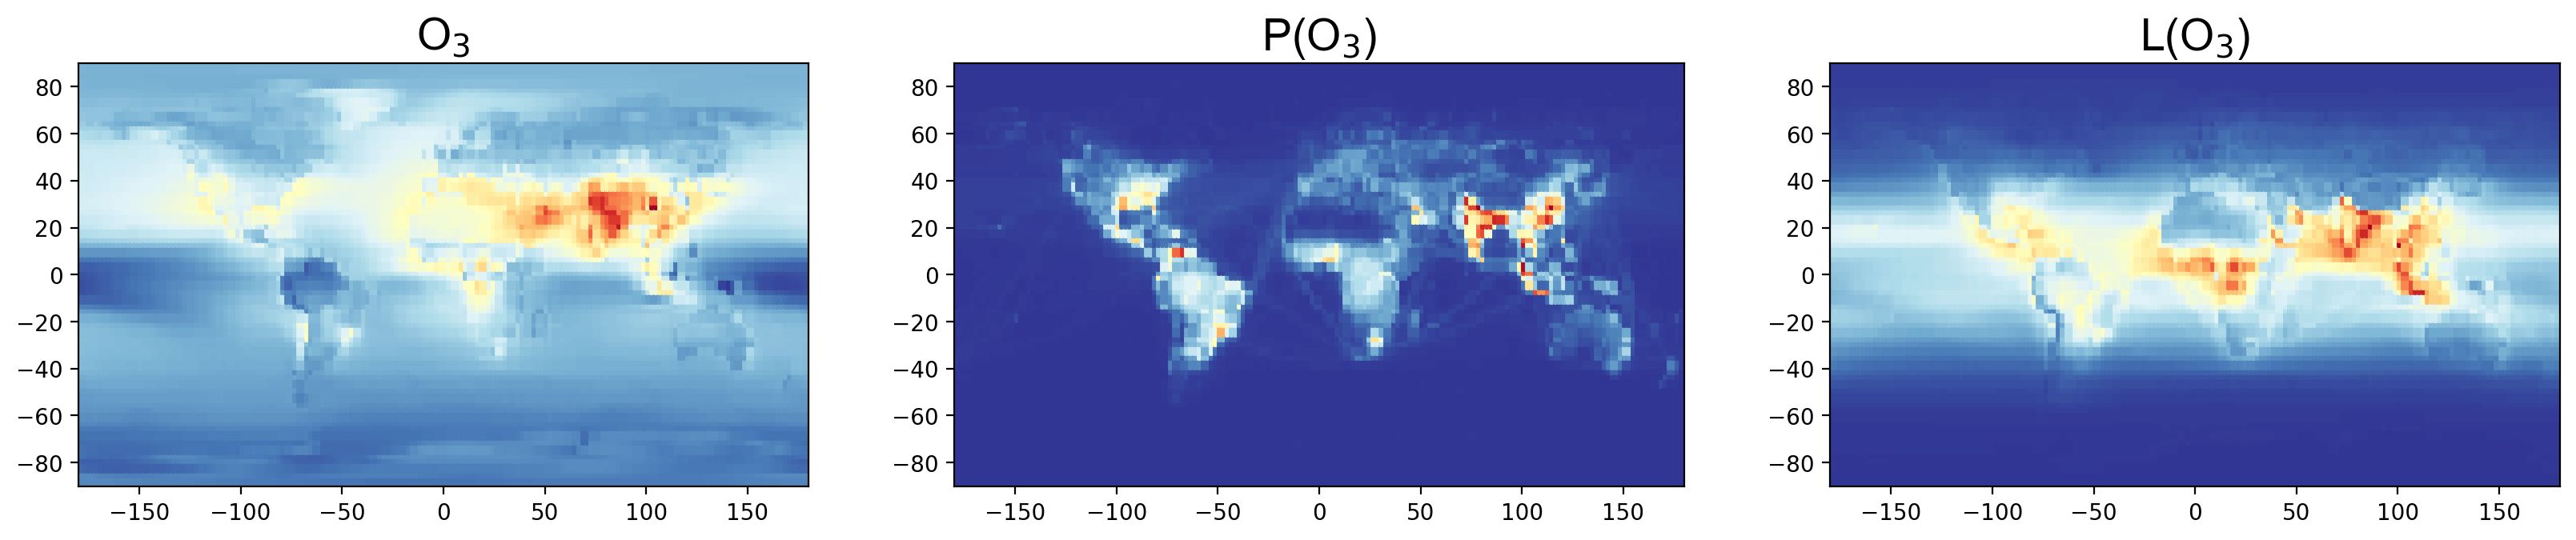

In [82]:
dataset_map = dataset_adj.groupby('loc').mean()
temp = dataset_map

plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('O${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('P(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3prod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('L(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3loss'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

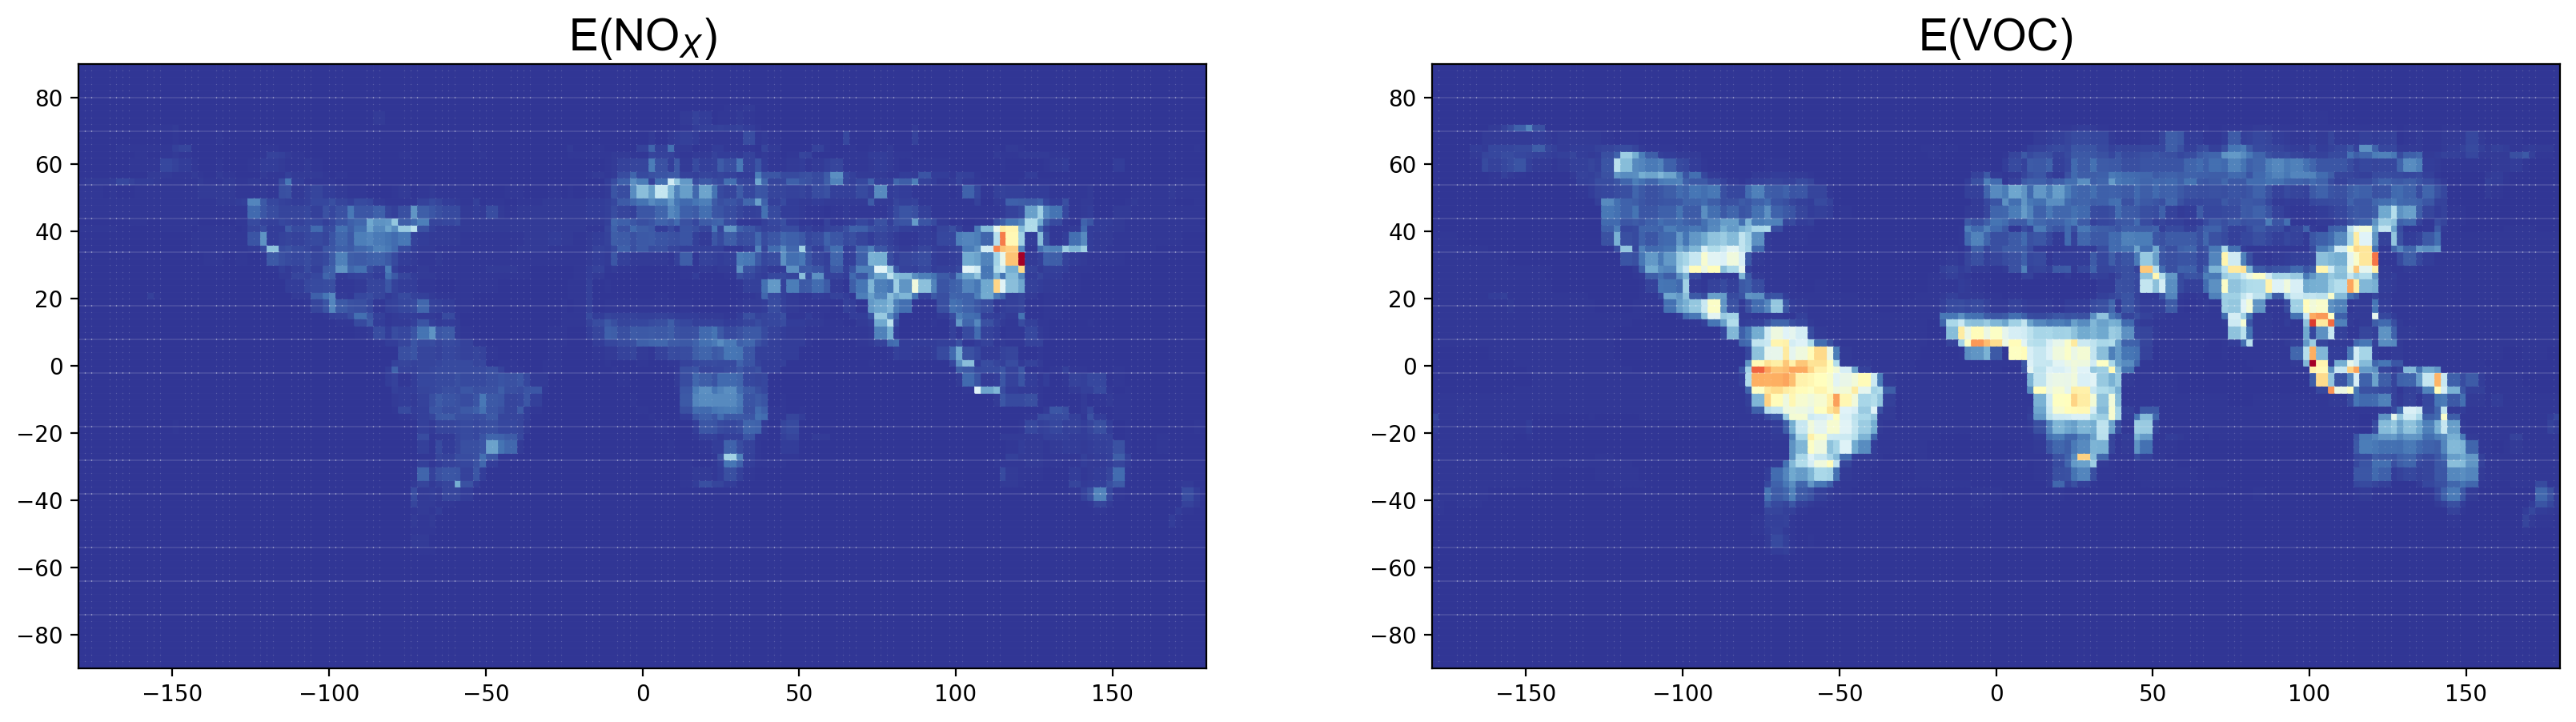

In [83]:
plt.figure(num=None, figsize=(20, 5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,2,1)
plt.title('E(NO${_X}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['eminox'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,2,2)
plt.title('E(VOC)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['emivoc'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

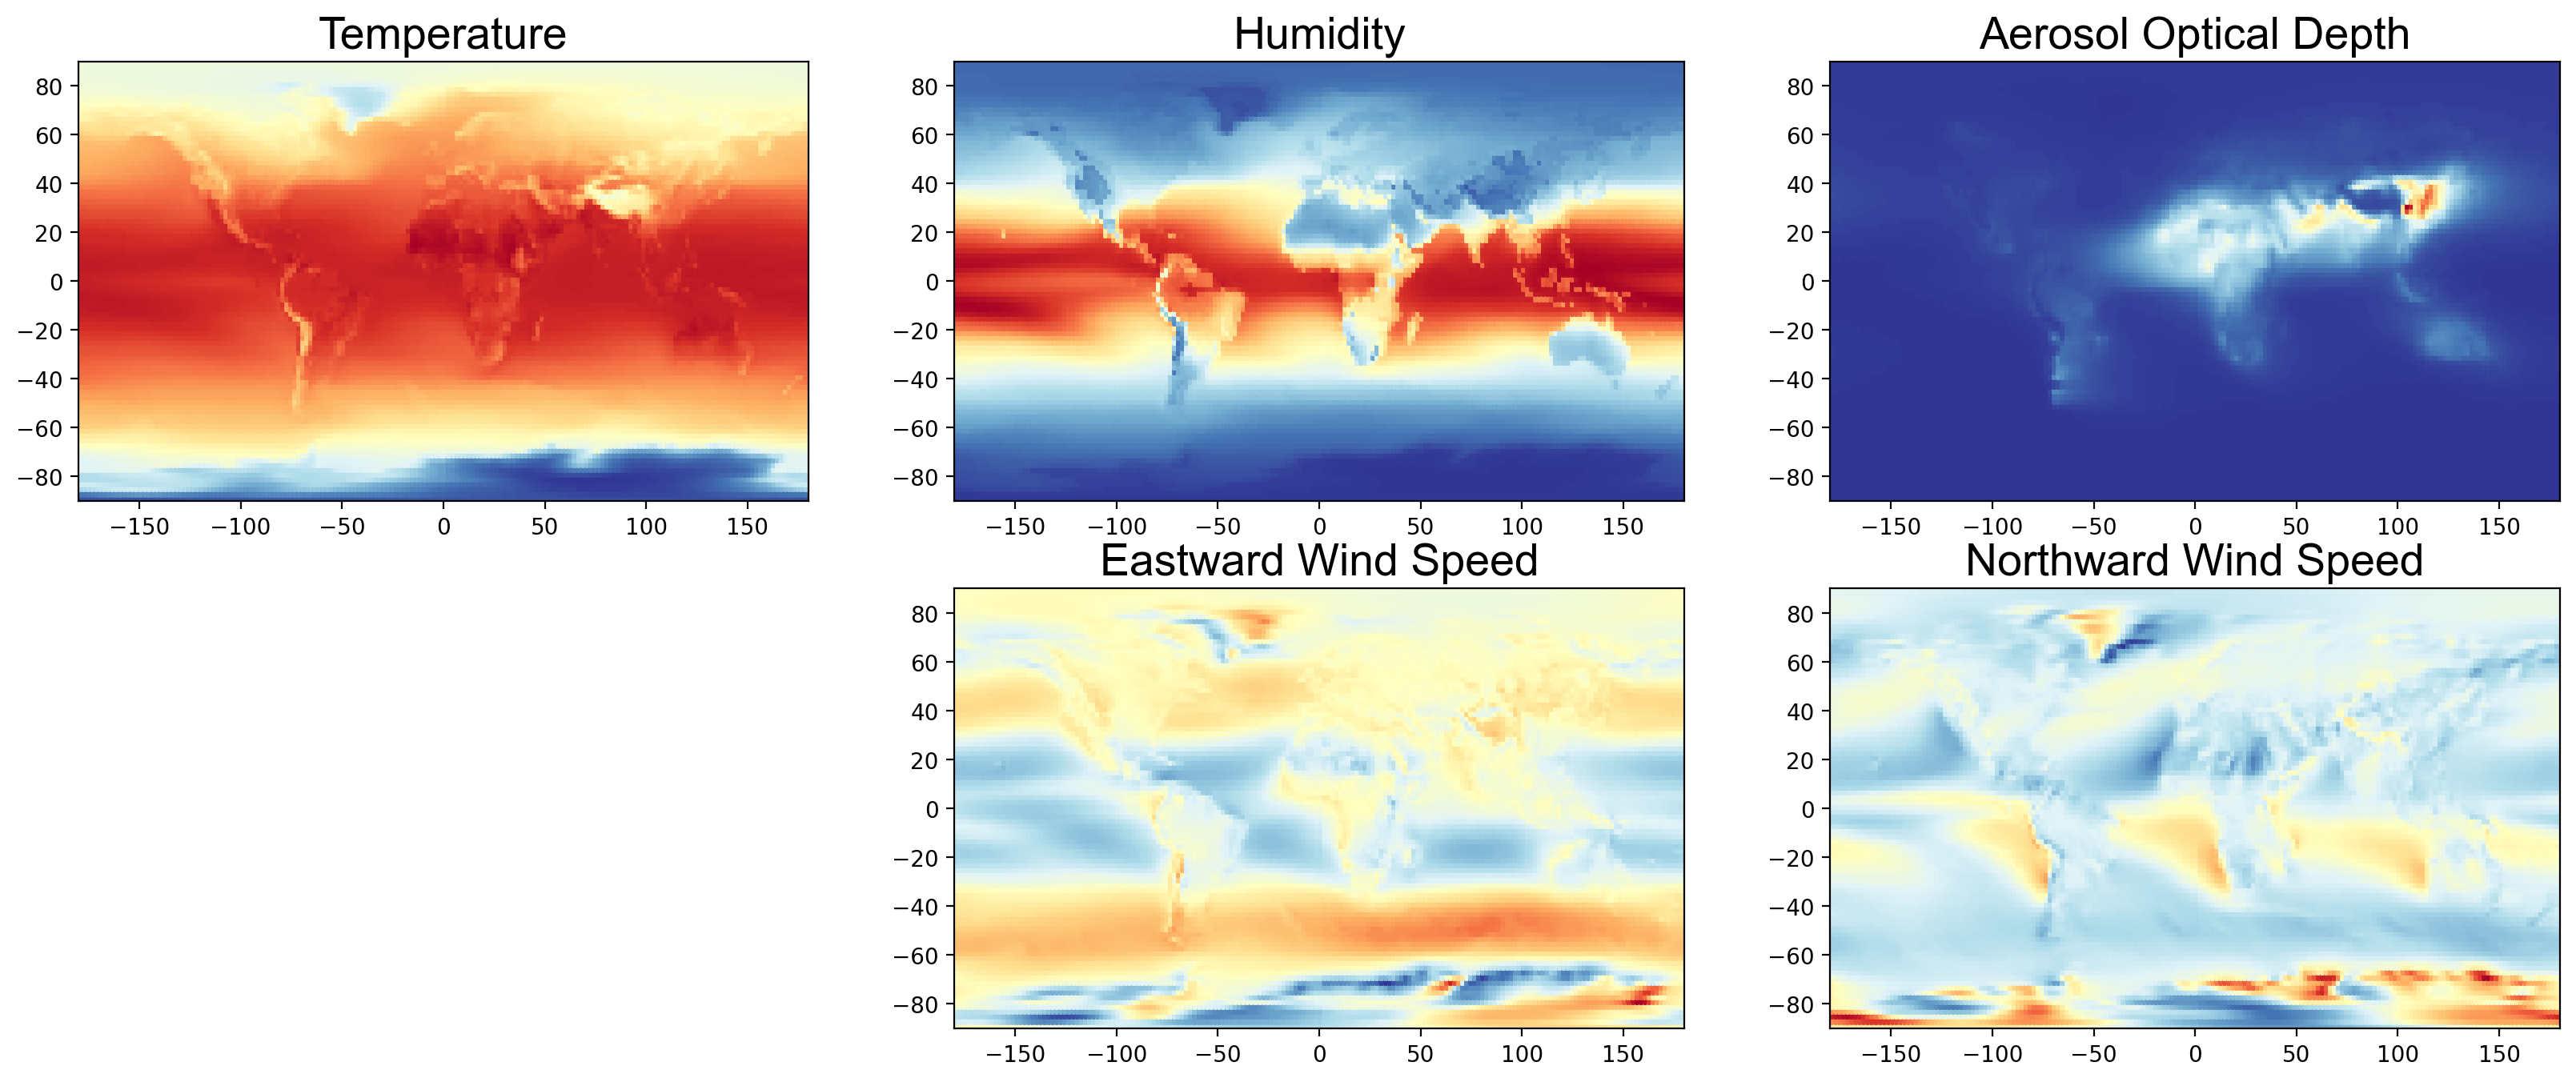

In [84]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('Temperature', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['tas'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('Humidity', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['hus'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('Aerosol Optical Depth', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['aod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('Eastward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['ua'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('Northward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['va'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

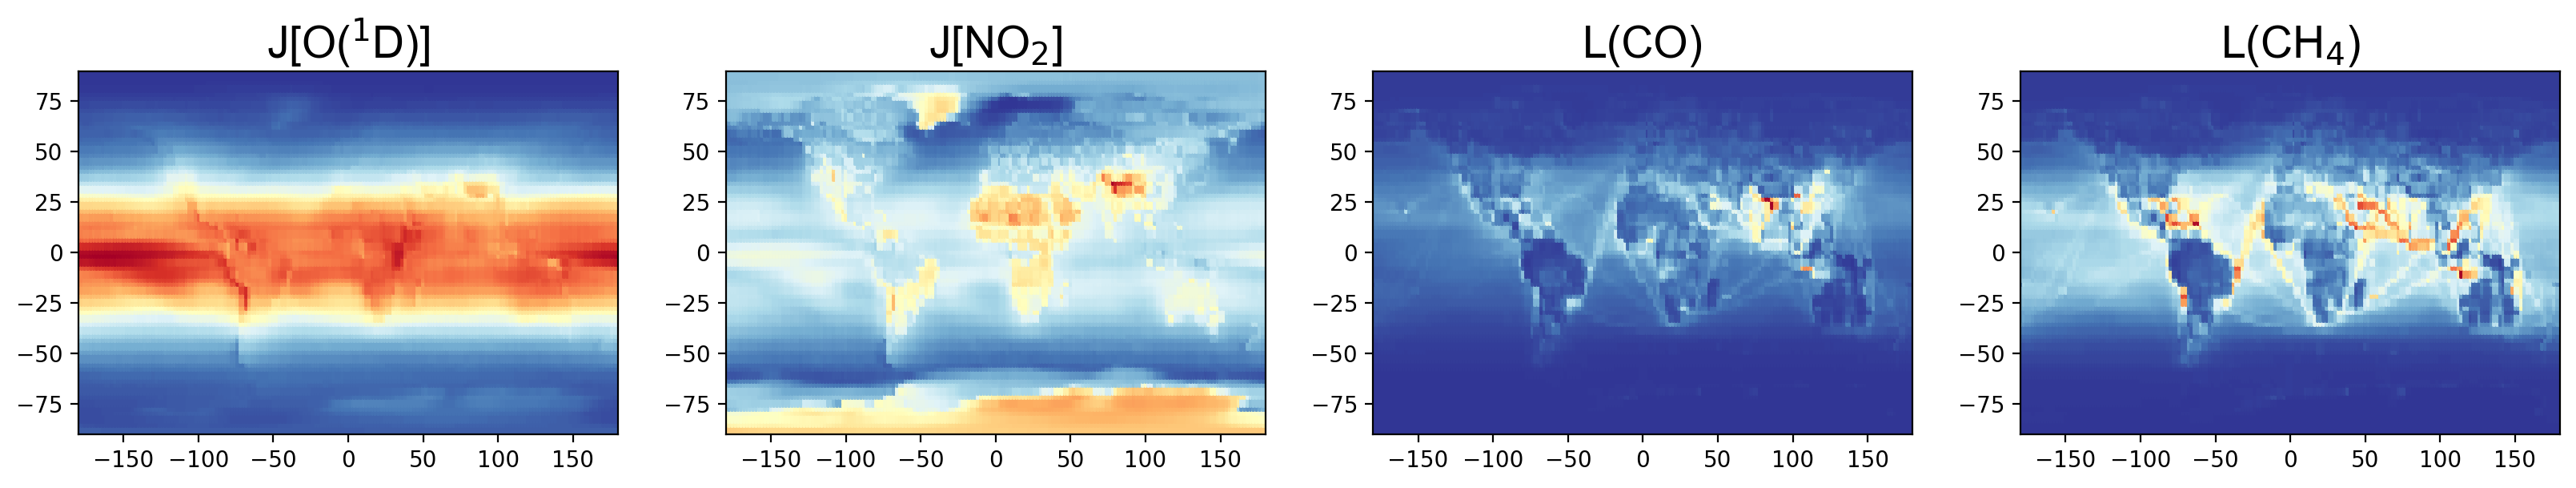

In [85]:
plt.figure(num=None, figsize=(20, 3), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(1,4,1)
plt.title('J[O(${^1}$D)]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['photo1d'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,2)
plt.title('J[NO${_2}$]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['jno2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,3)
plt.title('L(CO)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossco'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,4)
plt.title('L(CH${_4}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossch4'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

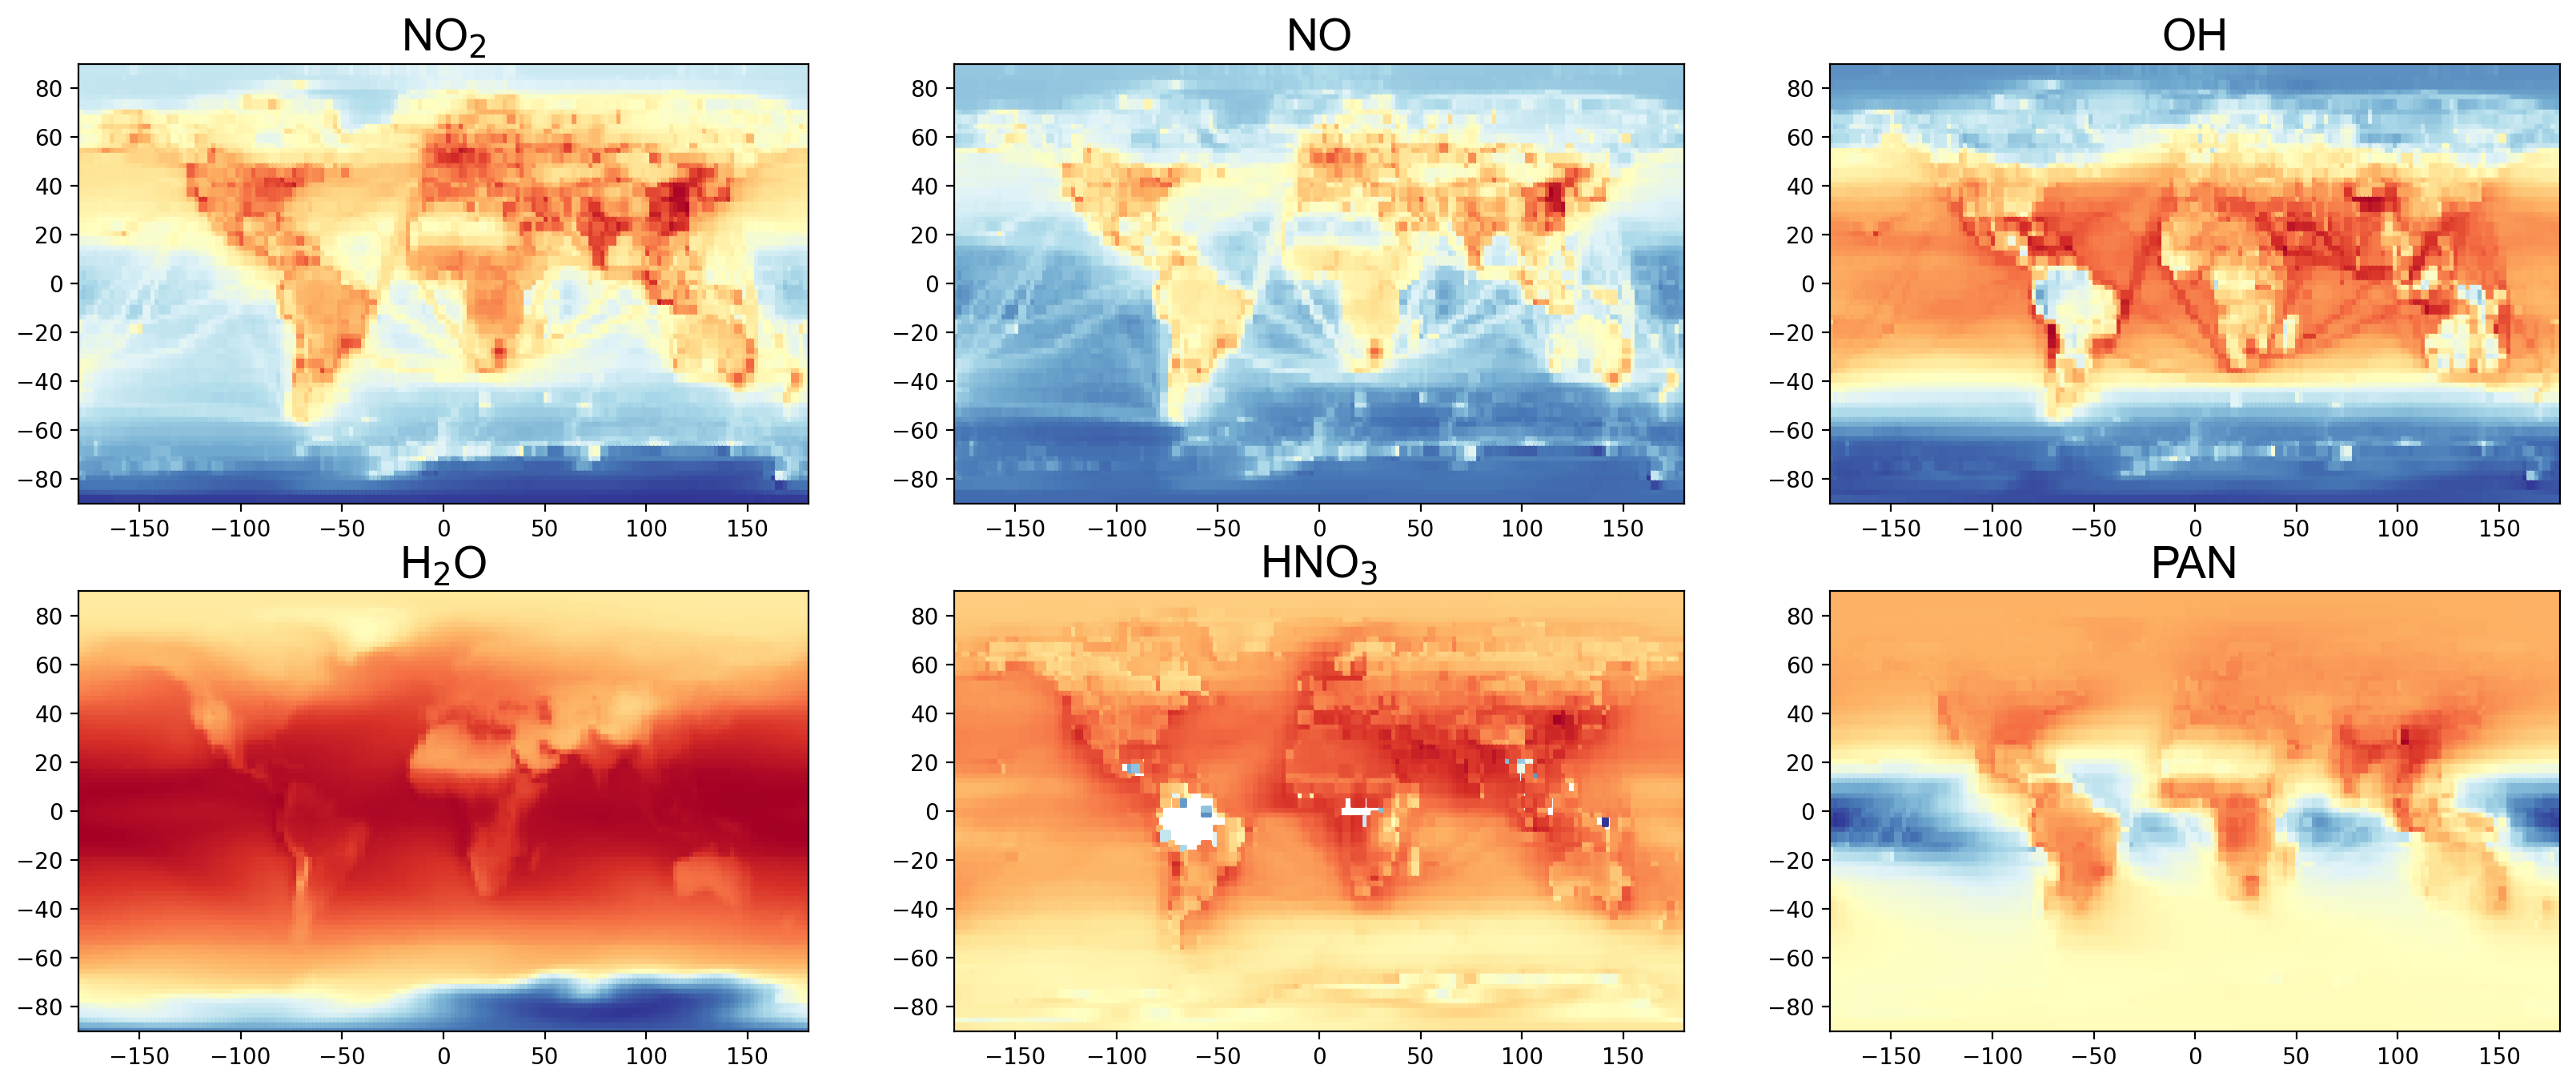

In [86]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('NO${_2}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('NO', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('OH', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['oh'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('H${_2}$O', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['h2o'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('HNO${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['hno3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('PAN', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['pan'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

#### We should now check whether each variable has been correctly extracted without any erroneous values (e.g. negative concentrations), and the sample sizes are all year×12×lon×lat. 

In [87]:
dataset_adj['eminox'].describe()

count    9.720000e+05
mean     2.633854e-12
std      9.283495e-12
min      0.000000e+00
25%      9.285304e-15
50%      1.422184e-13
75%      1.214905e-12
max      3.274905e-10
Name: eminox, dtype: float64

In [88]:
dataset_adj['emivoc'].describe()

count    9.720000e+05
mean     5.569847e-13
std      1.646182e-12
min      0.000000e+00
25%      5.472032e-15
50%      4.816773e-14
75%      1.057212e-13
max      1.175499e-10
Name: emivoc, dtype: float64

In [89]:
dataset_adj['o3'].describe()

count    9.720000e+05
mean     3.145474e-08
std      1.101236e-08
min      2.894585e-09
25%      2.359254e-08
50%      2.935632e-08
75%      3.736305e-08
max      1.329176e-07
Name: o3, dtype: float64

In [90]:
dataset_adj['o3prod'].describe()

count    9.720000e+05
mean     5.970434e-12
std      1.556284e-11
min      5.197459e-20
25%      5.603735e-14
50%      6.924643e-13
75%      3.611447e-12
max      3.566701e-10
Name: o3prod, dtype: float64

In [91]:
dataset_adj['o3loss'].describe()

count    9.720000e+05
mean     1.058304e-12
std      1.281132e-12
min      1.231970e-16
25%      5.363475e-14
50%      4.657616e-13
75%      1.828047e-12
max      1.846316e-11
Name: o3loss, dtype: float64

In [92]:
dataset_adj['tas'].describe()

count    972000.000000
mean        279.068207
std          21.126863
min         208.955811
25%         268.441368
50%         283.324860
75%         296.584229
max         318.368317
Name: tas, dtype: float64

In [93]:
dataset_adj['hus'].describe()

count    972000.000000
mean          0.007208
std           0.006066
min           0.000038
25%           0.002111
50%           0.005295
75%           0.011937
max           0.022279
Name: hus, dtype: float64

In [94]:
dataset_adj['aod'].describe()

count    972000.000000
mean          0.004273
std           0.010406
min           0.000020
25%           0.000226
50%           0.001001
75%           0.002930
max           0.243105
Name: aod, dtype: float64

In [95]:
dataset_adj['ua'].describe()

count    972000.000000
mean         -0.176974
std           4.488685
min         -22.395369
25%          -3.177917
50%          -0.093409
75%           2.615035
max          26.009827
Name: ua, dtype: float64

In [96]:
dataset_adj['va'].describe()

count    972000.000000
mean          0.243793
std           3.286978
min         -17.976061
25%          -1.828587
50%           0.038610
75%           2.044453
max          22.964163
Name: va, dtype: float64

In [97]:
dataset_adj['jno2'].describe()

count    972000.000000
mean       2337.379883
std        1818.114136
min           0.000000
25%        1190.747406
50%        2295.553955
75%        2909.149963
max       11914.428711
Name: jno2, dtype: float64

In [98]:
dataset_adj['photo1d'].describe()

count    972000.000000
mean          4.692092
std           4.299253
min           0.000000
25%           0.564752
50%           3.549229
75%           8.568036
max          18.119125
Name: photo1d, dtype: float64

In [99]:
dataset_adj['no2'].describe()

count    9.720000e+05
mean     3.682636e-10
std      1.139875e-09
min      3.857346e-15
25%      1.064885e-11
50%      4.853275e-11
75%      2.403596e-10
max      2.625027e-08
Name: no2, dtype: float64

In [100]:
dataset_adj['no'].describe()

count    9.720000e+05
mean     7.043397e-11
std      5.497918e-10
min      4.227503e-18
25%      1.454683e-12
50%      6.912316e-12
75%      3.170617e-11
max      6.299782e-08
Name: no, dtype: float64

In [101]:
dataset_adj['oh'].describe()

count    9.720000e+05
mean     4.224684e-14
std      4.873779e-14
min      5.572052e-18
25%      3.658785e-15
50%      2.113084e-14
75%      7.253126e-14
max      6.930095e-13
Name: oh, dtype: float64

In [102]:
dataset_adj['h2o'].describe()

count    972000.000000
mean          0.007518
std           0.006092
min           0.000009
25%           0.002446
50%           0.005799
75%           0.012503
max           0.022914
Name: h2o, dtype: float64

In [103]:
dataset_adj['hno3'].describe()

count    9.720000e+05
mean     5.568652e-11
std      2.317446e-10
min      0.000000e+00
25%      5.417675e-13
50%      4.451612e-12
75%      2.403924e-11
max      1.221856e-08
Name: hno3, dtype: float64

In [104]:
dataset_adj['pan'].describe()

count    9.720000e+05
mean     1.038478e-10
std      1.646800e-10
min      3.476937e-14
25%      1.233165e-11
50%      3.465381e-11
75%      1.609720e-10
max      1.081077e-08
Name: pan, dtype: float64

In [105]:
dataset_adj['lossco'].describe()

count    9.720000e+05
mean     1.070817e-12
std      1.443055e-12
min      9.035755e-17
25%      7.518780e-14
50%      5.404818e-13
75%      1.555037e-12
max      2.840667e-11
Name: lossco, dtype: float64

In [106]:
dataset_adj['lossch4'].describe()

count    9.720000e+05
mean     4.518014e-13
std      5.504884e-13
min      8.543480e-18
25%      2.105053e-14
50%      1.898832e-13
75%      7.955618e-13
max      4.462325e-12
Name: lossch4, dtype: float64

#### We should then check the scale of the kinetic rate coefficients with the IUPAC suggested values. 

##### The preferred value as 8.5×10$^{–12}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [107]:
dataset_adj['k_no_ho2'].median()

8.5582200050354e-12

##### The preferred value as 7.7×10$^{–12}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [108]:
dataset_adj['k_no_ch3o2'].median()

8.195091295242309e-12

##### The preferred value as 2.14×10$^{–10}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [109]:
dataset_adj['k_o1d_h2o'].median()

2.0144597506523133e-10

##### The preferred value as 2.0×10$^{–15}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [110]:
dataset_adj['k_o3_ho2'].median()

1.80408852853292e-15

##### The preferred value as 7.3×10$^{–14}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [111]:
dataset_adj['k_o3_oh'].median()

6.159847564995289e-14